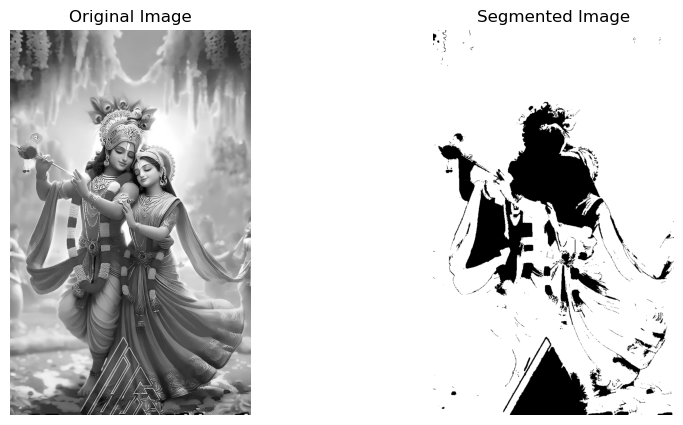

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def region_growing(image, seed, threshold):
    # Initialize the segmentation result
    segmented_image = np.zeros_like(image)
    height, width = image.shape[:2]

    # List of points to be checked
    check_points = [seed]

    # List of directions for 8-connected neighbors
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]

    while check_points:
        x, y = check_points.pop(0)

        # Avoid re-checking points
        if segmented_image[y, x] != 0:
            continue

        # Mark the current point as part of the region
        segmented_image[y, x] = 255

        # Check the neighbors
        for dx, dy in directions:
            nx, ny = x + dx, y + dy

            # Ensure the neighbor is within the image boundaries
            if 0 <= nx < width and 0 <= ny < height:
                # Calculate the intensity difference
                if abs(int(image[ny, nx]) - int(image[y, x])) < threshold:
                    # Add the neighbor to the list of points to be checked
                    check_points.append((nx, ny))

    return segmented_image

# Load the image
image = cv2.imread('radhakrishn.jpg', cv2.IMREAD_GRAYSCALE)

# Define the seed point and threshold
seed_point = (100, 100)  # Example seed point
threshold_value = 10  # Example threshold value

# Apply region growing
segmented_result = region_growing(image, seed_point, threshold_value)

# Display the original and segmented images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_result, cmap='gray')
plt.title('Segmented Image')
plt.axis('off')

plt.show()


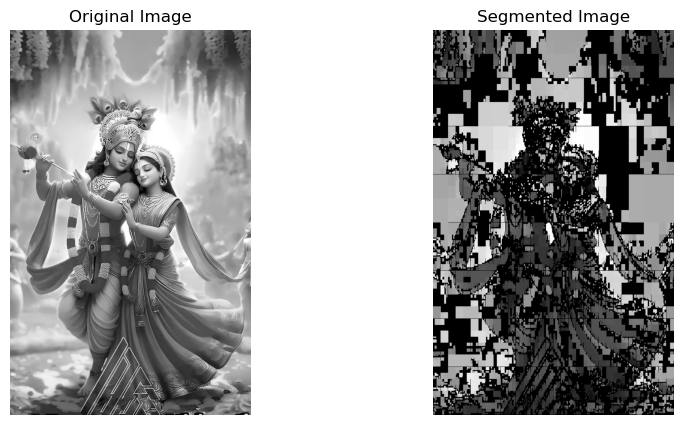

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def split_and_merge(image, threshold):
    def split(image, x, y, w, h, threshold):
        # Base case: if the region is smaller than 1x1, return the region
        if w <= 1 or h <= 1:
            return [(x, y, w, h)]
        
        # Calculate the mean and standard deviation of the region
        region = image[y:y+h, x:x+w]
        mean, stddev = cv2.meanStdDev(region)
        
        # If the standard deviation is less than the threshold, return the region
        if stddev[0][0] < threshold:
            return [(x, y, w, h)]
        
        # Otherwise, split the region into four subregions
        half_w, half_h = w // 2, h // 2
        regions = []
        regions.extend(split(image, x, y, half_w, half_h, threshold))
        regions.extend(split(image, x + half_w, y, half_w, half_h, threshold))
        regions.extend(split(image, x, y + half_h, half_w, half_h, threshold))
        regions.extend(split(image, x + half_w, y + half_h, half_w, half_h, threshold))
        
        return regions
    
    def merge(regions, image, threshold):
        def find_neighbors(regions, region):
            neighbors = []
            x, y, w, h = region
            for (nx, ny, nw, nh) in regions:
                if (nx == x + w or nx + nw == x) and ny == y and nh == h:
                    neighbors.append((nx, ny, nw, nh))
                elif (ny == y + h or ny + nh == y) and nx == x and nw == w:
                    neighbors.append((nx, ny, nw, nh))
            return neighbors
        
        merged = np.zeros_like(image, dtype=np.uint8)
        for region in regions:
            x, y, w, h = region
            neighbors = find_neighbors(regions, region)
            region_mean = np.mean(image[y:y+h, x:x+w])
            merge_region = True
            for neighbor in neighbors:
                nx, ny, nw, nh = neighbor
                neighbor_mean = np.mean(image[ny:ny+nh, nx:nx+nw])
                if abs(region_mean - neighbor_mean) > threshold:
                    merge_region = False
                    break
            if merge_region:
                cv2.rectangle(merged, (x, y), (x+w, y+h), int(region_mean), cv2.FILLED)
        return merged

    # Split the image
    height, width = image.shape
    regions = split(image, 0, 0, width, height, threshold)

    # Merge the regions
    merged_image = merge(regions, image, threshold)
    
    return merged_image

# Load the image
image = cv2.imread('radhakrishn.jpg', cv2.IMREAD_GRAYSCALE)

# Define the threshold
threshold_value = 10  # Example threshold value

# Apply region splitting and merging
segmented_result = split_and_merge(image, threshold_value)

# Display the original and segmented images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_result, cmap='gray')
plt.title('Segmented Image')
plt.axis('off')

plt.show()


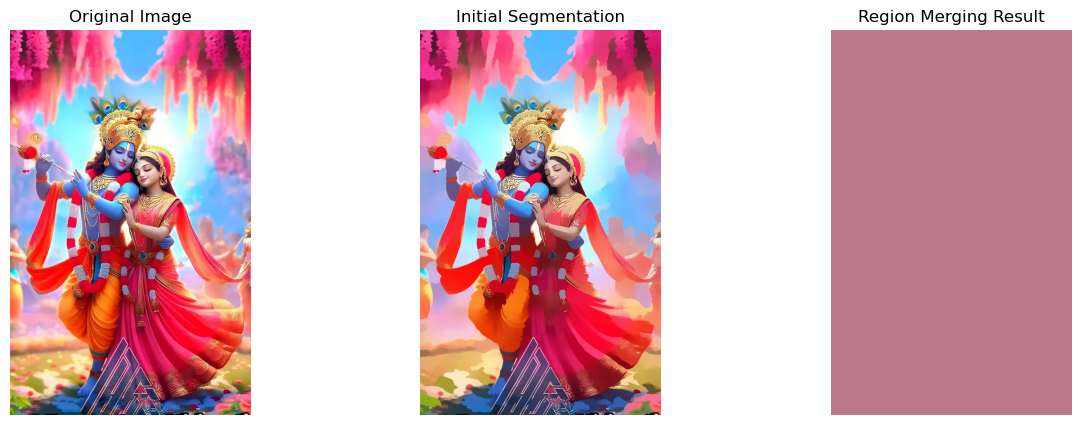

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def initial_segmentation(image, spatial_radius=21, color_radius=51):
    """
    Perform initial segmentation using mean shift filtering.
    """
    return cv2.pyrMeanShiftFiltering(image, sp=spatial_radius, sr=color_radius)

def merge_regions(image, labels, threshold):
    """
    Merge regions based on color similarity.
    """
    height, width = image.shape[:2]
    segmented_image = np.zeros_like(image)
    
    # Create a dictionary to store mean colors of regions
    mean_colors = {}
    
    for y in range(height):
        for x in range(width):
            label = labels[y, x]
            if label not in mean_colors:
                mean_colors[label] = []
            mean_colors[label].append(image[y, x])
    
    for label in mean_colors:
        mean_colors[label] = np.mean(mean_colors[label], axis=0)
    
    def find_neighbors(labels, label):
        neighbors = set()
        for y in range(height):
            for x in range(width):
                if labels[y, x] == label:
                    for dy in range(-1, 2):
                        for dx in range(-1, 2):
                            if 0 <= y+dy < height and 0 <= x+dx < width:
                                neighbor_label = labels[y+dy, x+dx]
                                if neighbor_label != label:
                                    neighbors.add(neighbor_label)
        return neighbors
    
    def merge(label, neighbors):
        region_color = mean_colors[label]
        for neighbor in neighbors:
            neighbor_color = mean_colors[neighbor]
            if np.linalg.norm(region_color - neighbor_color) < threshold:
                labels[labels == neighbor] = label
                mean_colors[label] = (mean_colors[label] + mean_colors[neighbor]) / 2
                del mean_colors[neighbor]
    
    unique_labels = np.unique(labels)
    
    for label in unique_labels:
        neighbors = find_neighbors(labels, label)
        merge(label, neighbors)
    
    for y in range(height):
        for x in range(width):
            segmented_image[y, x] = mean_colors[labels[y, x]]
    
    return segmented_image

# Load the image
image = cv2.imread('radhakrishn.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform initial segmentation
initial_segmented = initial_segmentation(image)

# Convert the initial segmentation result to labels
_, labels = cv2.connectedComponents(cv2.cvtColor(initial_segmented, cv2.COLOR_RGB2GRAY).astype(np.uint8))

# Define the threshold for merging regions
threshold_value = 30  # Example threshold value

# Merge the regions
merged_result = merge_regions(image, labels, threshold_value)

# Display the original, initial segmented, and final merged images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(initial_segmented)
plt.title('Initial Segmentation')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(merged_result)
plt.title('Region Merging Result')
plt.axis('off')

plt.show()


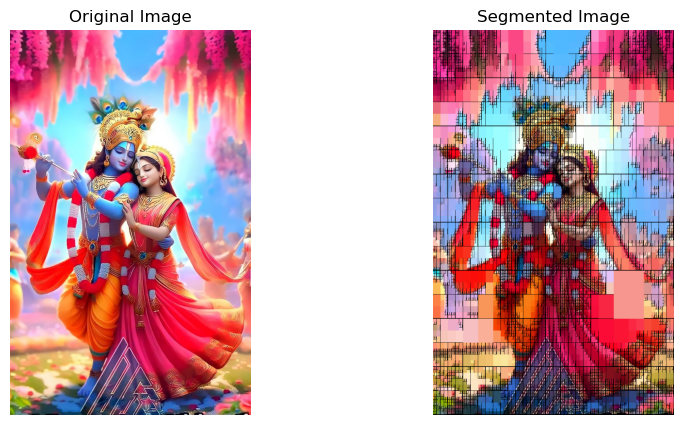

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def split(image, x, y, w, h, threshold):
    """
    Recursively split the image into regions based on a homogeneity criterion.
    """
    region = image[y:y+h, x:x+w]
    mean, stddev = cv2.meanStdDev(region)[:2]
    
    # If the region is homogeneous enough, return the region
    if stddev[0] < threshold:
        return [(x, y, w, h)]
    
    # If the region is too small to split, return the region
    if w <= 1 or h <= 1:
        return [(x, y, w, h)]
    
    # Otherwise, split the region into four subregions
    half_w, half_h = w // 2, h // 2
    regions = []
    regions.extend(split(image, x, y, half_w, half_h, threshold))
    regions.extend(split(image, x + half_w, y, half_w, half_h, threshold))
    regions.extend(split(image, x, y + half_h, half_w, half_h, threshold))
    regions.extend(split(image, x + half_w, y + half_h, half_w, half_h, threshold))
    
    return regions

def merge(image, regions, threshold):
    """
    Merge similar adjacent regions.
    """
    labels = np.zeros((image.shape[0], image.shape[1]), np.int32)
    current_label = 1

    for region in regions:
        x, y, w, h = region
        labels[y:y+h, x:x+w] = current_label
        current_label += 1

    merged = np.zeros_like(image, dtype=np.uint8)
    
    for i in range(1, current_label):
        mask = labels == i
        mean_color = cv2.mean(image, mask.astype(np.uint8))[:3]
        merged[mask] = mean_color

    return merged

def split_and_merge(image, threshold):
    """
    Perform region splitting and merging on the image.
    """
    height, width = image.shape[:2]
    regions = split(image, 0, 0, width, height, threshold)
    merged_image = merge(image, regions, threshold)
    return merged_image

# Load the image
image = cv2.imread('radhakrishn.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Define the threshold for homogeneity
threshold_value = 10  # Example threshold value

# Apply region splitting and merging
segmented_result = split_and_merge(image, threshold_value)

# Display the original and segmented images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_result)
plt.title('Segmented Image')
plt.axis('off')

plt.show()


In [6]:
pip install scikit-image


Note: you may need to restart the kernel to use updated packages.


In [7]:
import cv2
from segmentation import Region_Growing
import pydicom
import os, sys, getopt

DICOM_IMAGE_EXT = '.dcm'
OTHER_IMAGE_EXT = ['.jpg','.png', '.jpeg']
IMAGE_PATH = 'radhakrishn.jpg' # Default image path
CONN = 4

def run_region_growing_on_image(image_path):
   
    image_data, image_name = get_image_data(image_path)

    image_data = resize_image(image_data)

    image_data_post_smoothing = apply_gaussian_smoothing(image_data)

    region_growing(image_data_post_smoothing, segmentation_name=image_name+ " segmentation", neighbours=CONN)


def region_growing(image_data, neighbours, threshold=10, segmentation_name="Region Growing"):
    region_growing = Region_Growing(image_data, threshold=threshold, conn=neighbours)
    # Set Seeds
    region_growing.set_seeds()
    # Segmentation
    region_growing.segment()
    # Display Segmentation
    region_growing.display_and_resegment(name=segmentation_name)


def get_image_data(image_path):
    name, ext = os.path.splitext(image_path)
    if ext==DICOM_IMAGE_EXT:
        return (pydicom.read_file(image_path).pixel_array, name)
    elif ext in OTHER_IMAGE_EXT:
        return (cv2.imread(image_path,0), name)
    else:
        print("Invalid Image Format. Supported Image Formats are: {}, {}".format(DICOM_IMAGE_EXT, OTHER_IMAGE_EXT))
        sys.exit()


def resize_image(image_data):
    if image_data.shape[0]>1000:
        image_data = cv2.resize(image_data, (0,0), fx=0.25, fy=0.25)
    if image_data.shape[0]>500:
        image_data = cv2.resize(image_data, (0,0), fx=0.5, fy=0.5)
    return image_data


def apply_gaussian_smoothing(image_data, filter_size=3):
    return cv2.GaussianBlur(image_data,(filter_size,filter_size),0)


def set_cmd_line_arguments():
    global IMAGE_PATH
    global CONN
    n_args = len(sys.argv)
    if n_args==1: 
        print("No image path specified. TERMINATING!!")
        sys.exit()
    argv = sys.argv[1:]
    opts, args = getopt.getopt(argv,"",["image_path=", "conn="])
    for opt, arg in opts:
        if opt == "--image_path":
            IMAGE_PATH = arg
        elif opt == "--conn":
            print(arg)
            CONN= int(arg)
        else:
            print("Make sure to spell 'image_path' correctly")
            sys.exit()
    print("Image Path: {}".format(IMAGE_PATH))


if __name__ == "__main__":
    set_cmd_line_arguments()
    run_region_growing_on_image(IMAGE_PATH)

ModuleNotFoundError: No module named 'segmentation'

In [24]:
import sys
import cv2
import numpy as np

SAVE = 's'
ESC_KEY = 27

class Region_Growing():

    def __init__(self, img, threshold, conn=4):
        self.img = img
        self.segmentation = np.zeros(img.shape)
        self.threshold = threshold
        self.seeds = []
        if conn==4:
            self.orientations = [(1,0),(0,1),(-1,0),(0,-1)]
        elif conn == 8:
            self.orientations = [(1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1)] # 8 connectivity
        else:
            raise ValueError("(%s) Connectivity type not known (4 or 8 available)!" % (sys._getframe().f_code.co_name))


    def set_seeds(self, name="Region Growing"):
        """
        Set seed points using left mouse button. 
        """
        self.seeds = []
        self.img = np.array(self.img, dtype=np.uint8)
        cv2.namedWindow(name, cv2.WINDOW_NORMAL)
        cv2.setMouseCallback(name, self.__on_left_click)
        cv2.imshow(name, self.img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()


    def segment(self):
        """
        Segment the image with the provided user seeds using region growing
        """
        for seed in self.seeds:
            curr_pixel = [seed[1],seed[0]]
            if self.segmentation[curr_pixel[0], curr_pixel[1]]==255: continue # pixel already explored
            contour = []
            seg_size = 1
            mean_seg_value = (self.img[curr_pixel[0],curr_pixel[1]])
            dist = 0
            while(dist<self.threshold):
                # Include current pixel in segmentation
                self.segmentation[curr_pixel[0], curr_pixel[1]]=255
                # Explore neighbours of current pixel
                contour = self.__explore_neighbours(contour, curr_pixel)
                # Get the nearest neighbour
                nearest_neighbour_idx, dist = self.__get_nearest_neighbour(contour, mean_seg_value)
                # If no more neighbours to grow, move to the next seed
                if nearest_neighbour_idx==-1: break
                # Update Current pixel to the nearest neighbour and increment size
                curr_pixel = contour[nearest_neighbour_idx]
                seg_size+=1
                # Update Mean pixel value for segmentation
                mean_seg_value = (mean_seg_value*seg_size + float(self.img[curr_pixel[0],curr_pixel[1]]))/(seg_size+1)
                # Delete from contour once the nearest neighbour as chosen as the current node for expansion
                del contour[nearest_neighbour_idx]
        return self.segmentation


    def display_and_resegment(self, name="Region Growing"):
        self.seeds = []
        # Display original image where segmentation was not done
        result = np.maximum(self.img, self.segmentation)
        result = np.array(result, dtype=np.uint8)
        # Display the result 
        cv2.namedWindow(name, cv2.WINDOW_NORMAL)
        # Activate mouse click on the image window
        cv2.setMouseCallback(name, self.__on_left_click)
        cv2.imshow(name, result)
        key = cv2.waitKey(0)
        cv2.destroyAllWindows()
        # Press "s" to save the segmented result
        if chr(key)==SAVE: cv2.imwrite(name+'.png', result)
        # Press "Esc" to if no more seeds are required and end the program
        if key==ESC_KEY: return
        # Resegment the image using new seeds
        self.segment()
        self.display_and_resegment(name=name)


    def __explore_neighbours(self, contour, current_pixel):
        for orientation in self.orientations:
            neighbour = self.__get_neighbouring_pixel(current_pixel, orientation, self.img.shape)
            if neighbour is None:
                continue
            if self.segmentation[neighbour[0],neighbour[1]]==0:
                contour.append(neighbour)
                self.segmentation[neighbour[0],neighbour[1]]=150
        return contour


    def __get_neighbouring_pixel(self, current_pixel, orient, img_shape):
        neighbour = (current_pixel[0]+orient[0], current_pixel[1]+orient[1])
        if self.is_pixel_inside_image(pixel=neighbour, img_shape=img_shape):
            return neighbour
        else:
            return None


    def __get_nearest_neighbour(self, contour, mean_seg_value):
        dist_list = [abs(self.img[pixel[0], pixel[1]] - mean_seg_value) for pixel in contour]
        if len(dist_list)==0: return -1, 1000
        min_dist = min(dist_list)
        index = dist_list.index(min_dist)
        return index, min_dist


    def is_pixel_inside_image(self, pixel, img_shape):
        return 0<=pixel[0]<img_shape[0] and 0<=pixel[1]<img_shape[1]


    def __on_left_click(self, event, x, y, flags, param):
       
        if event == cv2.EVENT_LBUTTONDOWN:
            self.seeds.append((x, y))


Max Iterations
Iterations : 211727


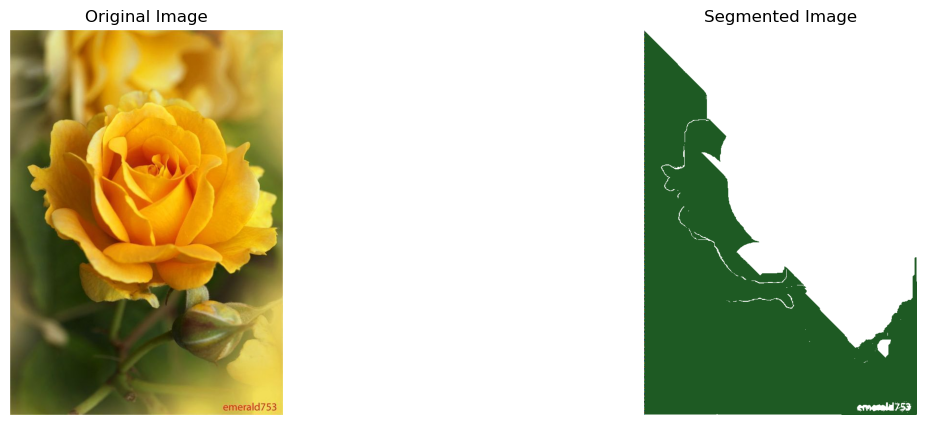

In [8]:
#region-growing
import cv2
import itertools
import numpy as np
import random
import sys
import matplotlib.pyplot as plt

# Class for a stack
class Stack():
    def __init__(self):
        self.item = []

    def push(self, value):
        self.item.append(value)

    def pop(self):
        return self.item.pop()

    def size(self):
        return len(self.item)

    def isEmpty(self):
        return self.size() == 0

    def clear(self):
        self.item = []

class regionGrow():
  
    def __init__(self,im_path,th):
        self.readImage(im_path)
        self.h, self.w,_ =  self.im.shape
        self.passedBy = np.zeros((self.h,self.w), np.double)
        self.currentRegion = 0
        self.iterations=0
        self.SEGS=np.zeros((self.h,self.w,3), dtype='uint8')
        self.stack = Stack()
        self.thresh=float(th)

    def readImage(self, img_path):
        self.im = cv2.imread(img_path,1).astype('int')

    def getNeighbour(self, x0, y0):
        return [
            (x, y)
            for i, j in itertools.product((-1, 0, 1), repeat=2)
            if (i, j) != (0, 0) and self.boundaries(x := x0 + i, y := y0 + j)
        ]

    def create_seeds(self):
        return [
            [self.h/2,self.w/2],
            [self.h/3,self.w/3],[2*self.h/3,self.w/3],[self.h/3-10,self.w/3],
            [self.h/3,2*self.w/3],[2*self.h/3,2*self.w/3],[self.h/3-10,2*self.w/3],
            [self.h/3,self.w-10],[2*self.h/3,self.w-10],[self.h/3-10,self.w-10]
                    ]

    def ApplyRegionGrow(self, cv_display = True):

        randomseeds = self.create_seeds()
        np.random.shuffle(randomseeds)

        for x0 in range (self.h):
            for y0 in range (self.w):

                if self.passedBy[x0,y0] == 0:  
                    self.currentRegion += 1
                    self.passedBy[x0,y0] = self.currentRegion
                    self.stack.push((x0,y0))
                    self.prev_region_count= 0

                    while not self.stack.isEmpty():
                        x,y = self.stack.pop()
                        self.BFS(x,y)
                        self.iterations+=1

                    if self.PassedAll():
                        break

                    if self.prev_region_count< 8*8:     
                        x0, y0 = self.reset_region(x0, y0)

        if self.iterations>200000:
            print("Max Iterations")
        print(f"Iterations : {str(self.iterations)}")

        if cv_display:
            [self.color_pixel(i,j) for i, j in itertools.product(range(self.h), range (self.w))]
            self.display("Rose1.jpg")

    def reset_region(self, x0, y0):

        self.passedBy[self.passedBy==self.currentRegion] = 0
        x0=random.randint(x0-4,x0+4)
        y0=random.randint(y0-4,y0+4)
        x0 = np.clip(x0, 0, self.h - 1)
        y0 = np.clip(y0, 0, self.w - 1)
        self.currentRegion-=1
        return x0, y0

    def color_pixel(self, i, j):
        val = self.passedBy[i][j]
        self.SEGS[i][j] = (255, 255, 255) if (val==0) else (val*35, val*90, val*30)

    def display(self, original_image_path):
        # Convert BGR to RGB
        segs_rgb = cv2.cvtColor(self.SEGS, cv2.COLOR_BGR2RGB)

        original_image = cv2.imread(original_image_path)
        original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(original_image_rgb)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(segs_rgb)
        plt.title('Segmented Image')
        plt.axis('off')

        
        plt.show()

    def BFS(self, x0,y0):

        regionNum = self.passedBy[x0,y0]
        
        elems = [np.mean(self.im[x0, y0])]

        var=self.thresh

        neighbours=self.getNeighbour(x0,y0)

        for x,y in neighbours:
            if self.passedBy[x,y] == 0 and self.distance(x,y,x0,y0) < var:

                if self.PassedAll():
                    break

                self.passedBy[x,y] = regionNum
                self.stack.push((x,y))
                elems.append(np.mean(self.im[x,y]))
                var=np.var(elems)
                self.prev_region_count+=1
            var=max(var,self.thresh)
                
    def PassedAll(self, max_iteration = 200000):
        return self.iterations > max_iteration or np.all(self.passedBy > 0)

    def boundaries(self, x,y):
        return  0<=x<self.h and 0<=y<self.w
    
    def distance(self,x,y,x0,y0):
        return np.linalg.norm(self.im[x0, y0] - self.im[x, y])

# Example usage
exemple = regionGrow("Rose1.jpg", "15")
exemple.ApplyRegionGrow()
